# Compare single wake results in all cases

Expand comparison to all single wakes occuring in aligned simulations across 8-9 m/s

In [1]:
import matplotlib.pyplot as plt
import floris.tools as wfct
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import pickle
from scipy.optimize import minimize

## Load FLORIS models and SOWFA DATA

In [2]:
df = pickle.load( open( "sowfa_04.p", "rb" ) )
fi_dict = pickle.load( open( "floris_models_2.p", "rb" ) )

## Limit DF to tuning cases

In [3]:
print(df.shape)

(679, 18)


In [4]:
# Limit to aligned only
df = df[df.yaw.apply(lambda x: np.max(np.abs(x)))==0.0]

In [5]:
# Limit to 8 or 9 m/s (or not, comment out)
# df = df[df.sowfa_U0<10]
df.shape

(133, 18)

In [6]:
# Get the single wake results in all simulations
results_df = pd.DataFrame()

for floris_key in fi_dict:
    (fi, floris_color, floris_label) = fi_dict[floris_key]

    # Set up FLORIS to match
    # Determine free-stream wind speed column
    freestream_name = 'freestream_' + floris_label

    # For the tuned case, drop the tune name and reuses
    freestream_name = freestream_name.replace('_tune','')
    
    for i, row in df.iterrows():


        # Match the layout
        if floris_label == 'gauss_legacy':
                fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                               wind_speed=[row[freestream_name]],
                              turbulence_intensity=[row.floris_TI])
        else:
            fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                                       wind_speed=[row[freestream_name]],
                                      turbulence_intensity=[row.freestream_ti])

        fi.calculate_wake()

        floris_power = np.array(fi.get_turbine_power())/1000.

        # Now sort out the powers by wakes
        upstream_idx = np.where(row.wake_table==0)
        sowfa_upstream_power = np.mean(row.power[upstream_idx])
        floris_upstream_power = np.mean(floris_power[upstream_idx])

        single_wake_indices = np.where(row.wake_table==1)
        single_wake_indices
        for idx in single_wake_indices:
            sowfa_downstream_power = np.mean(row.power[idx])
            floris_downstream_power = np.mean(floris_power[idx])

            # Make a dictionary entry for this row
            result_dict = {'sowfa_upstream_power':[sowfa_upstream_power],
                           'sowfa_downstream_power':[sowfa_downstream_power],
                           'floris_upstream_power':[floris_upstream_power],
                           'floris_downstream_power':[floris_downstream_power],
                           'sowfa_wake_loss':[sowfa_upstream_power - sowfa_downstream_power],
                           'floris_wake_loss':[floris_upstream_power - floris_downstream_power],
                           'floris_label':[floris_label],
                           'sowfa_U0':row.sowfa_U0,
                           'sowfa_TI':row.sowfa_TI
                          }
            # temp_df = 
            results_df = results_df.append(pd.DataFrame(result_dict))
    
results_df.head()

,sowfa_upstream_power,sowfa_downstream_power,floris_upstream_power,floris_downstream_power,sowfa_wake_loss,floris_wake_loss,floris_label,sowfa_U0,sowfa_TI
0,1937.5,1072.3,1937.499995,1200.628820,865.2,736.871175,gauss,8.0,0.1
0,1938.0,752.7,1937.999995,860.900597,1185.3,1077.099398,gauss,8.0,0.1
0,1936.5,1217.5,1936.499995,1199.829447,719.0,736.670548,gauss,8.0,0.1
0,1544.4,777.9,1544.399996,851.831530,766.5,692.568466,gauss,8.0,0.1
0,1940.5,849.7,1940.499995,967.554354,1090.8,972.945641,gauss,8.0,0.1


## How do things compare?

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


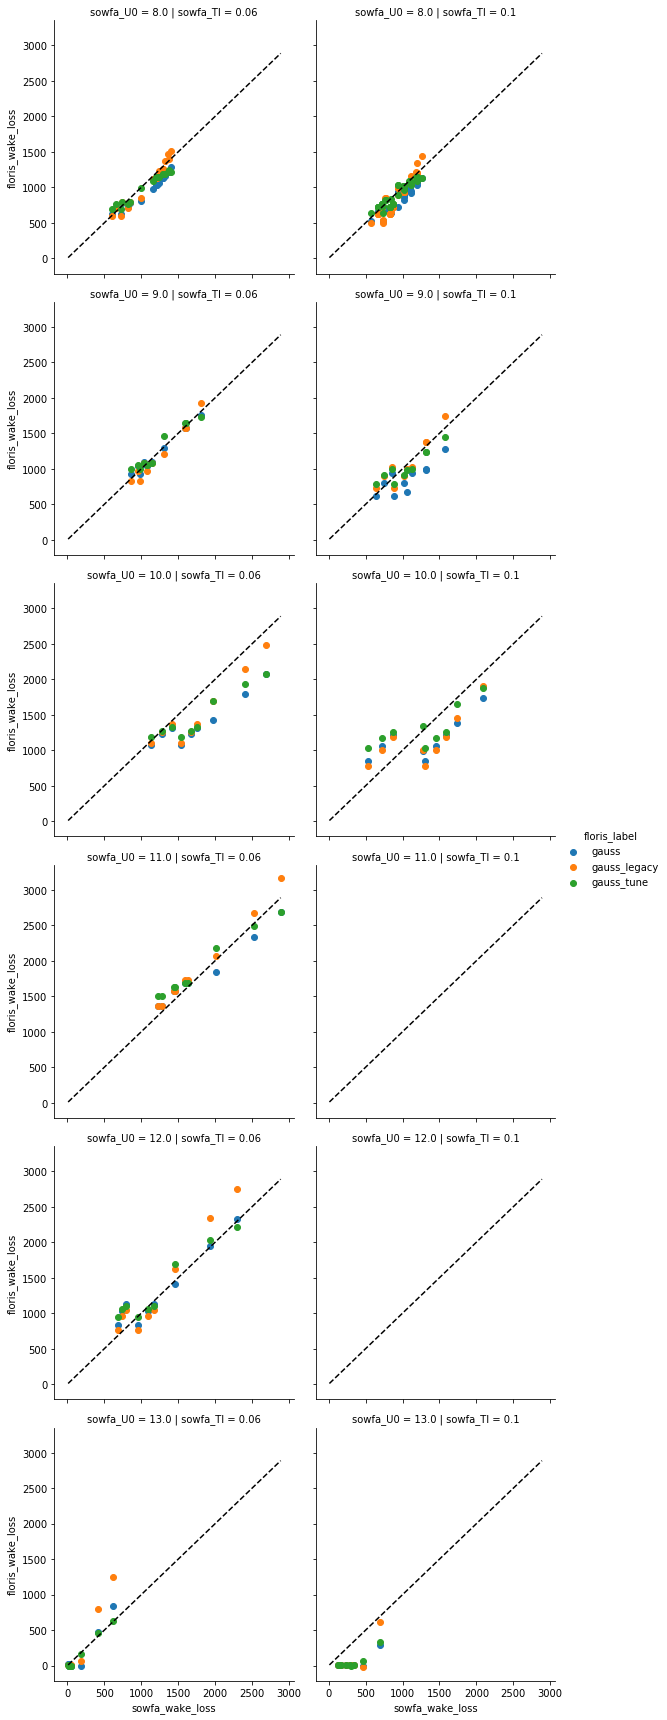

In [7]:
g = sns.FacetGrid(results_df,row='sowfa_U0', col='sowfa_TI',hue='floris_label',size=4)
g.map(plt.scatter,'sowfa_wake_loss','floris_wake_loss')
for ax in g.axes.flatten():
    ax.plot([results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],
            [results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],'k--')
g.add_legend()

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


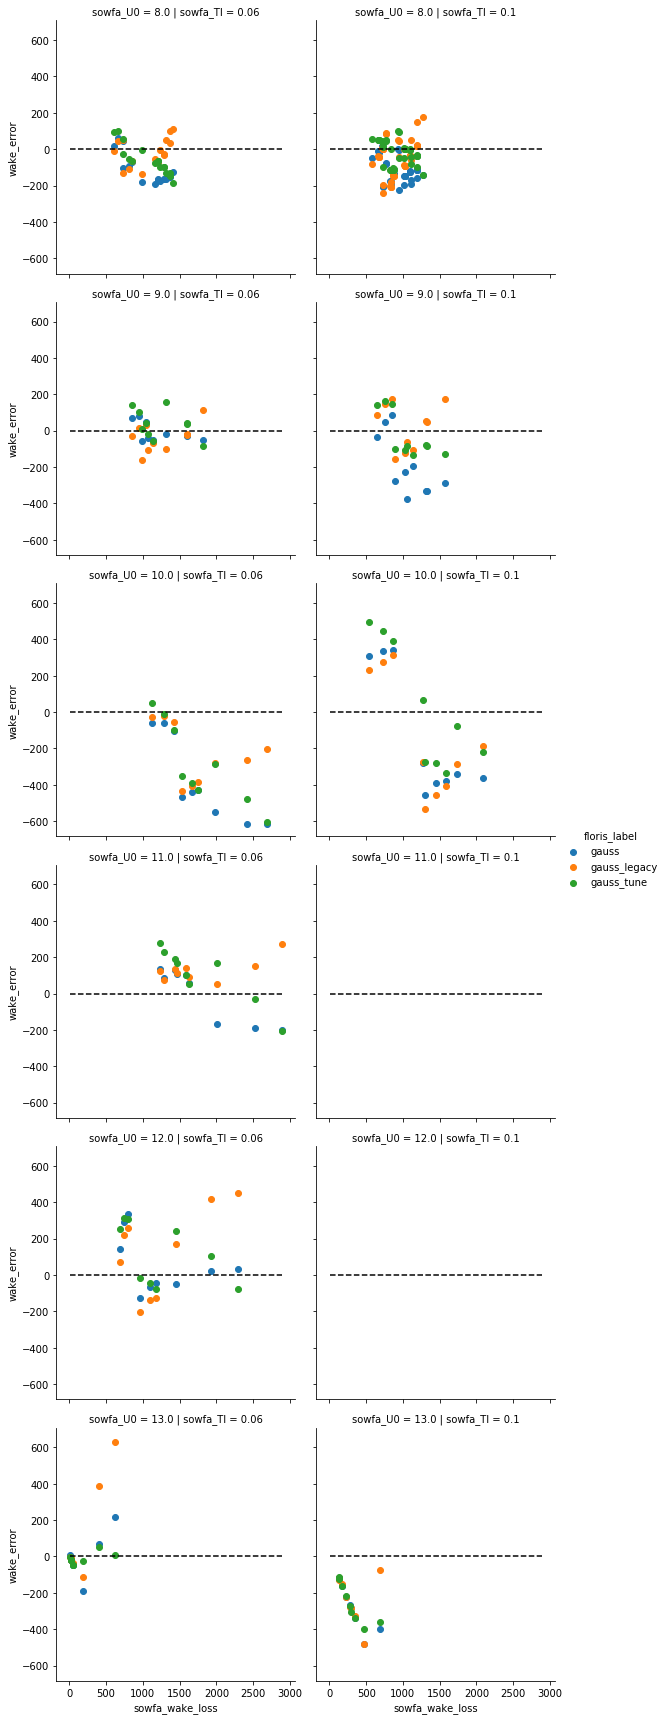

In [9]:
results_df['wake_error'] = results_df.floris_wake_loss - results_df.sowfa_wake_loss
g = sns.FacetGrid(results_df,row='sowfa_U0', col='sowfa_TI',hue='floris_label',size=4)
g.map(plt.scatter,'sowfa_wake_loss','wake_error')
for ax in g.axes.flatten():
    ax.plot([results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],
            [0,0],'k--')
g.add_legend()

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


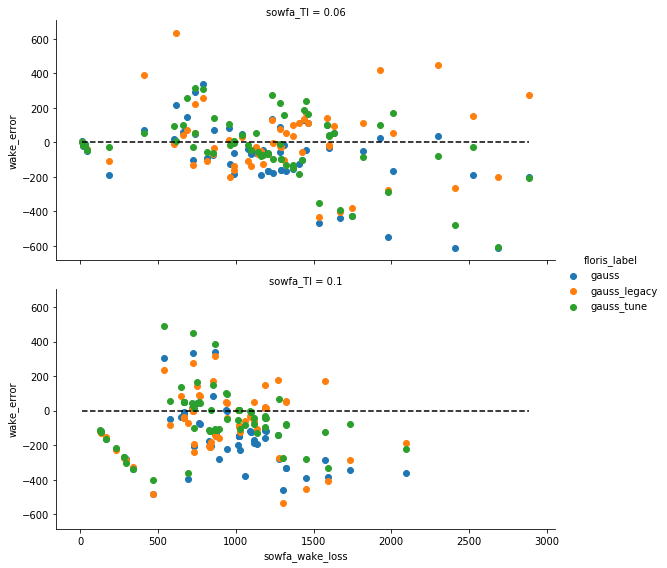

In [10]:
results_df['wake_error'] = results_df.floris_wake_loss - results_df.sowfa_wake_loss
g = sns.FacetGrid(results_df,row='sowfa_TI',hue='floris_label',size=4,aspect=2)
g.map(plt.scatter,'sowfa_wake_loss','wake_error')
for ax in g.axes.flatten():
    ax.plot([results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],
            [0,0],'k--')
g.add_legend()

In [11]:
# Check for an overall bias and rms
results_df[['wake_error','floris_label']].groupby('floris_label').agg([np.mean,np.median,lambda x: np.sqrt(np.sum(x**2)/len(x))])

wake_error                        
                    mean      median    <lambda>
floris_label                                    
gauss        -113.067526 -120.033568  209.203008
gauss_legacy  -37.839599  -37.820385  185.015440
gauss_tune    -34.818793  -33.120449  172.317526

`We've reduced bias and RMS error across cases, new tuning seems acceptable